### Import required libraries

In [30]:
from scipy.io import arff
import math
import pandas as pd
from pandas import DataFrame
import sys, getopt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import decomposition
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV,RFE
from sklearn.feature_selection import VarianceThreshold
%matplotlib inline


### File preprocessing : Convert arff to csv

In [4]:
def arff2csv(arff_path, csv_path=None, _encoding='utf8'):
    with open(arff_path, 'r', encoding=_encoding) as fr:
        attributes = []
        if csv_path is None:
            csv_path = arff_path[:-4] + 'csv'  # *.arff -> *.csv
        write_sw = False
        with open(csv_path, 'w', encoding=_encoding) as fw:
            for line in fr.readlines():
                if write_sw:
                    fw.write(line)
                elif '@data' in line:
                    fw.write(','.join(attributes) + '\n')
                    write_sw = True
                elif '@attribute' in line:
                    attributes.append(line.split()[1])  # @attribute attribute_tag numeric
    print("Convert {} to {}.".format(arff_path, csv_path))

arff2csv('Behavior of the urban traffic - modified.arff', 'Behavior of the urban traffic - modified.csv')
pd.set_option('display.max_columns', None)
"""-1 under missing value?"""
missing_values = [-1," ", ""]
df = pd.read_csv('Behavior of the urban traffic - modified.csv', na_values = missing_values);

Convert Behavior of the urban traffic - modified.arff to Behavior of the urban traffic - modified.csv.


### Data Pre processing

In [12]:
df.dtypes

Hour                                     float64
Immobilized_bus                          float64
Broken_Truck                             float64
Vehicle_excess                           float64
Accident_victim                          float64
Running_over                              object
Fire_vehicles                             object
Occurrence_involving_freight             float64
Incident_involving_dangerous_freight     float64
Lack_of_electricity                      float64
Fire                                     float64
Point_of_flooding                        float64
Manifestations                           float64
Defect_in_the_network_of_trolleybuses    float64
Tree_on_the_road                         float64
Semaphore_off                            float64
Intermittent_Semaphore                   float64
Slowness_in_traffic_percent              float64
dtype: object

#### Data transformation

In [21]:
# Remove trailing and leading spaces from all field values in the dataset.
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Drop duplicate records
DataFrame.drop_duplicates(df, inplace = True);

# Based on manual analysis
df = df.drop(['Fire_vehicles'],axis=1)
df = df.drop(['Occurrence_involving_freight'],axis=1)
df = df.drop(['Incident_involving_dangerous_freight'],axis=1)
df = df.drop(['Fire'],axis=1)
df = df.drop(['Intermittent_Semaphore'],axis=1)

# Mapping values in certain features : Categorical feature values transformed to numeric

#df['Fire_vehicles'] = df['Fire_vehicles'].map({'YES': 1, 'NO': 0});
df['Vehicle_excess'] = df['Vehicle_excess'].map({'T': 1, 'F': 0,'t': 1, 'f': 0,'NO': 0, 'YES': 1  })
df['Running_over'] = df['Running_over'].replace({'NO': 0, 'YES': 1})
df['Hour'] = df['Hour'].map({'7:00':1,'7:30':2,'8:00':3,'8:30':4,'9:00':5,'9:30':6,'10:00':7,                             '10:30':8,'11:00':9,'11:30':10,'12:00':11,'12:30':12,'13:00':13,
'13:30':14,'14:00':15,'14:30':16,'15:00':17,'15:30':18,'16:00':19,'16:30':20,
'17:00':21,'17:30':22,'18:00':23,'18:30':24,'19:00':25,'19:30':26,'20:00':27})

df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 0 to 138
Data columns (total 18 columns):
Hour                                     0 non-null float64
Immobilized_bus                          130 non-null float64
Broken_Truck                             130 non-null float64
Vehicle_excess                           0 non-null float64
Accident_victim                          130 non-null float64
Running_over                             129 non-null object
Fire_vehicles                            130 non-null object
Occurrence_involving_freight             130 non-null float64
Incident_involving_dangerous_freight     128 non-null float64
Lack_of_electricity                      130 non-null float64
Fire                                     130 non-null float64
Point_of_flooding                        130 non-null float64
Manifestations                           130 non-null float64
Defect_in_the_network_of_trolleybuses    130 non-null float64
Tree_on_the_road                 

#### Identify features having missing values

In [16]:
print(df.isnull().sum())
print('no of records - ', df.shape)
print(df.info())
print(df.head())

Hour                                     140
Immobilized_bus                            0
Broken_Truck                               0
Vehicle_excess                           140
Accident_victim                            2
Running_over                               1
Fire_vehicles                              0
Occurrence_involving_freight               0
Incident_involving_dangerous_freight       2
Lack_of_electricity                        0
Fire                                       0
Point_of_flooding                          0
Manifestations                             0
Defect_in_the_network_of_trolleybuses      2
Tree_on_the_road                           0
Semaphore_off                              1
Intermittent_Semaphore                     0
Slowness_in_traffic_percent                0
dtype: int64
no of records -  (140, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 18 columns):
Hour                                     0 no

##### Check the distribution of missing values for each feature : Visualisation

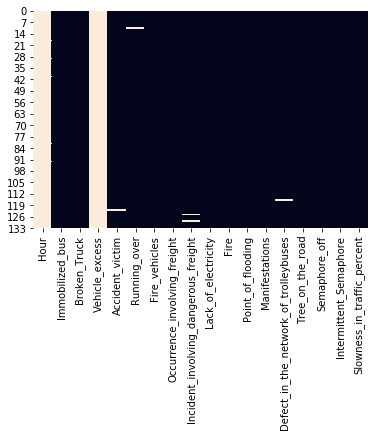

In [15]:
sns.heatmap(df.isnull(), cbar=False)

#### Missing value imputation

In [18]:
df['Accident_victim'].fillna(math.floor(df['Accident_victim'].mean()), inplace=True)
df['Vehicle_excess'].fillna(0,inplace=True);
df['Running_over'].fillna(0,inplace=True);
#df['Fire_vehicles'].fillna(0,inplace=True);
#df['Incident_involving_dangerous_freight'].fillna(0,inplace=True);
df['Manifestations'].fillna(0,inplace=True);
df['Defect_in_the_network_of_trolleybuses'].fillna(0,inplace=True);
df['Semaphore_off'].fillna(0,inplace=True);

#### Univariate analysis : Checking for outliers

<Figure size 432x288 with 0 Axes>

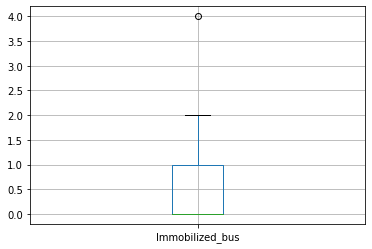

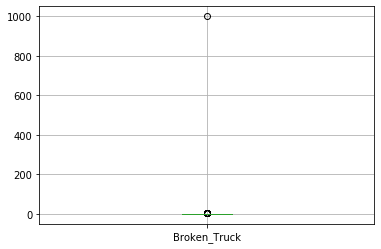

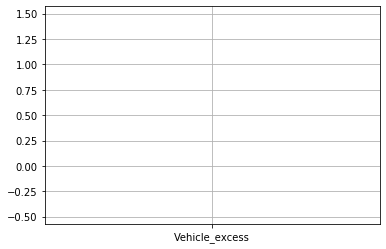

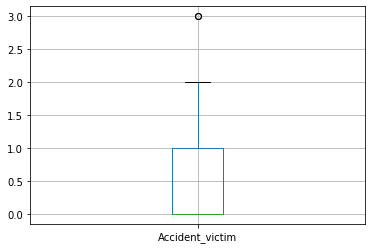

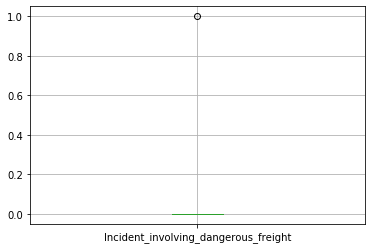

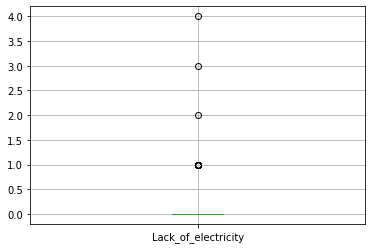

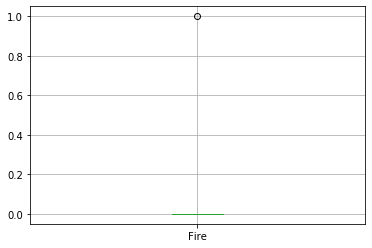

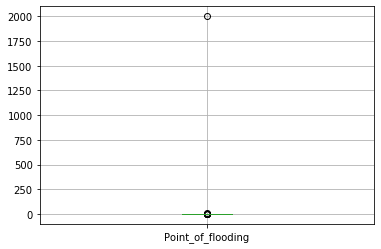

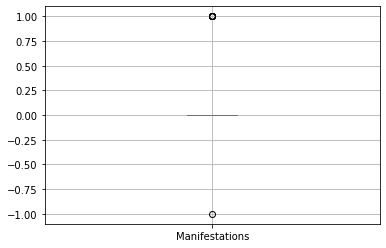

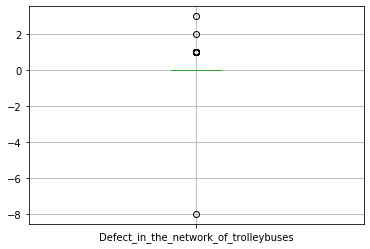

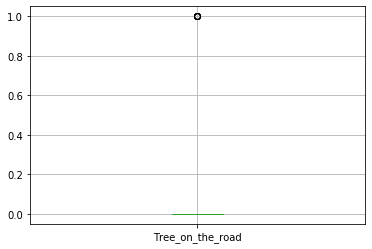

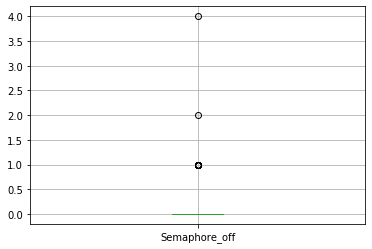

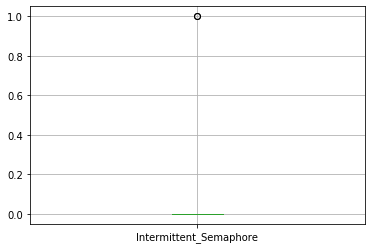

<Figure size 432x288 with 0 Axes>

In [27]:
boxplot = df.boxplot(column=['Immobilized_bus'])
plt.figure()
boxplot = df.boxplot(column=['Broken_Truck'])
plt.figure()
boxplot = df.boxplot(column=['Vehicle_excess'])
plt.figure()
boxplot = df.boxplot(column=['Accident_victim'])
plt.figure()
"""boxplot = df.boxplot(column=['Running_over'])
plt.figure()
boxplot = df.boxplot(column=['Fire_vehicles'])
plt.figure()
boxplot = df.boxplot(column=['Occurrence_involving_freight'])
plt.figure()"""
boxplot = df.boxplot(column=['Incident_involving_dangerous_freight'])
plt.figure()
boxplot = df.boxplot(column=['Lack_of_electricity'])
plt.figure()
boxplot = df.boxplot(column=['Fire'])
plt.figure()
boxplot = df.boxplot(column=['Point_of_flooding'])
plt.figure()
boxplot = df.boxplot(column=['Manifestations'])
plt.figure()
boxplot = df.boxplot(column=['Defect_in_the_network_of_trolleybuses'])
plt.figure()
boxplot = df.boxplot(column=['Tree_on_the_road'])
plt.figure()
boxplot = df.boxplot(column=['Semaphore_off'])
plt.figure()
boxplot = df.boxplot(column=['Intermittent_Semaphore'])
plt.figure()





#### Remove outliers

In [28]:
# In order to be an outlier, the data value must be larger than Q3 by at least 1.5 times the interquartile range(or) smaller than Q1 by at least 1.5 times IQR.
# From the above observations, 2 outliers are identified.

df = df[df.Broken_Truck < 1000]
df = df[df.Point_of_flooding < 2000]
print (df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 0 to 138
Data columns (total 18 columns):
Hour                                     0 non-null float64
Immobilized_bus                          128 non-null float64
Broken_Truck                             128 non-null float64
Vehicle_excess                           0 non-null float64
Accident_victim                          128 non-null float64
Running_over                             128 non-null object
Fire_vehicles                            128 non-null object
Occurrence_involving_freight             128 non-null float64
Incident_involving_dangerous_freight     126 non-null float64
Lack_of_electricity                      128 non-null float64
Fire                                     128 non-null float64
Point_of_flooding                        128 non-null float64
Manifestations                           128 non-null float64
Defect_in_the_network_of_trolleybuses    128 non-null float64
Tree_on_the_road                 

#### Feature Selection

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 0 to 138
Data columns (total 16 columns):
Hour                                     0 non-null float64
Immobilized_bus                          128 non-null float64
Broken_Truck                             128 non-null float64
Vehicle_excess                           0 non-null float64
Accident_victim                          128 non-null float64
Occurrence_involving_freight             128 non-null float64
Incident_involving_dangerous_freight     126 non-null float64
Lack_of_electricity                      128 non-null float64
Fire                                     128 non-null float64
Point_of_flooding                        128 non-null float64
Manifestations                           128 non-null float64
Defect_in_the_network_of_trolleybuses    128 non-null float64
Tree_on_the_road                         128 non-null float64
Semaphore_off                            128 non-null float64
Intermittent_Semaphore         

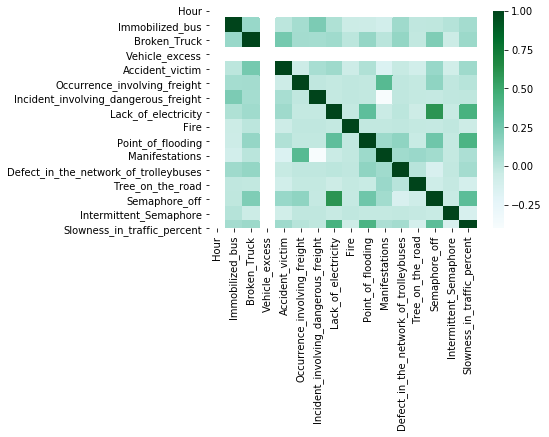

In [45]:
# Prepare train and test data
df.dtypes
numerical_columns = list(df.select_dtypes(include=['float64','int64']).columns)
df = df[numerical_columns]
feature_set = df.drop(['Slowness_in_traffic_percent'],axis=1)
target_variable = df['Slowness_in_traffic_percent']
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_variable, train_size=0.7,test_size=0.3,random_state=100)
print (df.info())

# Plot corelation matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='BuGn')

# Extract features that are highly corelated to 'Slowness in traffic', taking threshold as 0.1
correlated_features = set()
for i in range(len(correlation_matrix.drop(labels=['Slowness_in_traffic_percent'], axis=1).columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= 0.1:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(len(correlated_features))
cor_features = []
for i in correlated_features:
    cor_features.append(i)
    
print("Highly corelated features: ",cor_features)






#### Identify collinearity among the features selected (from corelation matrix) : Multivariate analysis

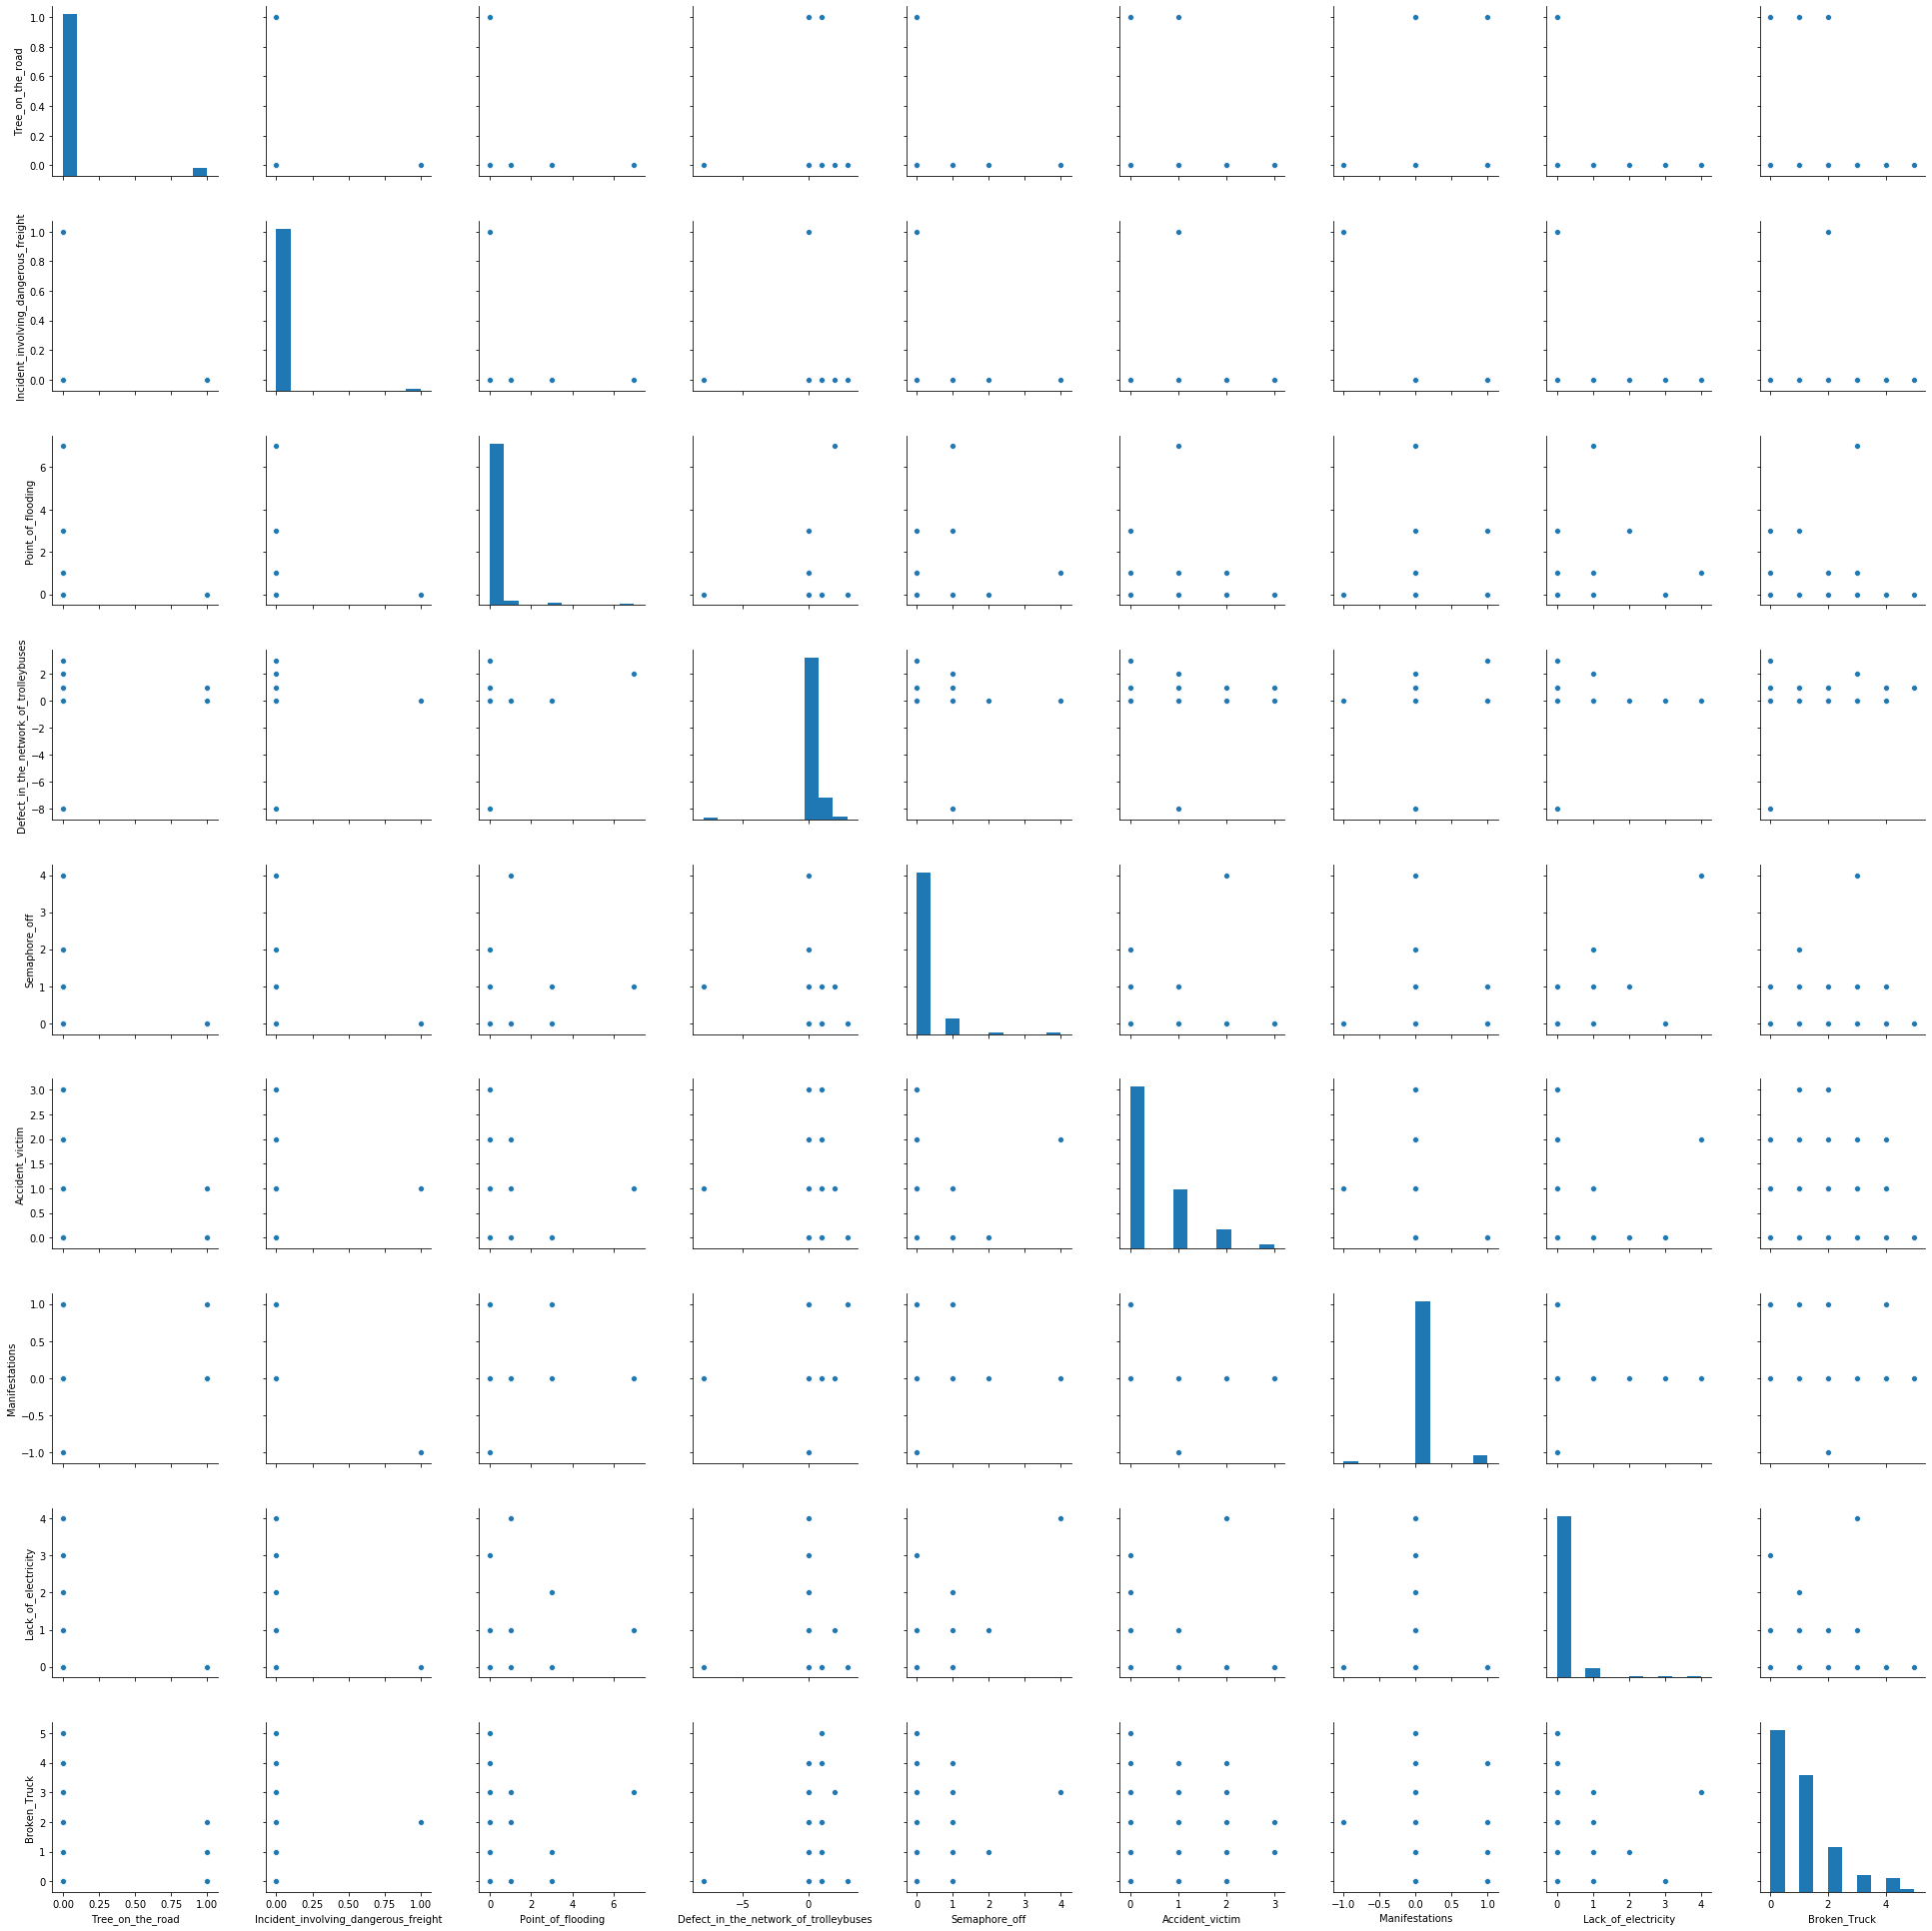

In [46]:
sns.pairplot(df[cor_features],height = 3)

#### Based on the above observation, below features are the top contributors to slowness in traffic.

##### 1. Semaphore off 2. Accident victim 3. Point of flooding 4. Broken truck

### Model building and evaluation

#### Model 1 : We use Dimensionality reduction using PCA [Feature Extraction] technique, to arrive at the best feature subset contributing to slowness in traffic.

In [78]:
X_train_scaled = StandardScaler().fit_transform(X_train) # normalizing the features
X_test_scaled  = StandardScaler().fit_transform(X_test) # normalizing the features

pca = PCA(n_components=6)
pca.fit(X_train)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

X_train_transformed  = pca.transform(X_train_scaled);
print("PCA transforfm data", X_train_transformed)

X_test_transformed  = pca.transform(X_test_scaled);

# Create the model
model1 = LinearRegression()
# Train the model, using training data set
model1.fit(X_train_transformed, y_train)

# The coefficients

# print the parameter theta1
print('Coefficient = Theta1 = ', model1.coef_)
# print the parameter theta0
print('Intercept = Theta0 = ', model1.intercept_)

y_predicted = model1.predict(X_test_transformed)

print ("predicted slowness value", y_predicted)

print("model score:",model1.score(X_test_transformed, y_test))
#print("accuracy score:",accuracy_score(y_test, y_predicted))
print("mean squared error",mean_squared_error(y_test, y_predicted))
print('Variance score = %.2f' % r2_score(y_test, y_predicted))







[58.79734724  1.11420416  0.65531847  0.49799063  0.3998636   0.19923295]
[0.94760859 0.01795709 0.01056145 0.00802588 0.00644441 0.00321094]
[0.94760859 0.96556568 0.97612714 0.98415301 0.99059742 0.99380836]
PCA transforfm data [[ 1.45012138e+01 -1.37083238e+00  5.28397015e-01 -3.85334985e-02
  -7.01708575e-01 -2.46253032e-01]
 [ 1.37105837e+01  1.43871274e-01 -5.34326583e-01  3.39202638e+00
   8.53046709e-01 -4.71892796e-01]
 [ 1.27233832e+01  1.01284987e+00  4.96010992e+00 -4.53353982e-01
   2.87508554e-01 -3.08267538e+00]
 [ 1.25960842e+01 -1.01248920e+00 -1.55253475e-02  2.30759448e+00
   4.49306304e-01 -3.22758044e-01]
 [ 1.34036094e+01 -1.10111548e+00  8.33447655e-03  2.39725272e+00
   6.96318819e-01 -4.64554017e-01]
 [ 1.47325253e+01 -4.69728602e-01  2.67057634e-01 -1.52772899e-01
  -9.04198993e-01 -3.28536240e-01]
 [ 1.30588366e+01 -1.43061354e+00  5.17004687e-01 -5.86535327e-02
  -7.25848376e-01 -2.23782359e-01]
 [ 1.37484645e+01 -2.73890380e-01  5.63396636e-01  8.95310393e-

#### Model 2 : We use Recursive Feature Elimination [Feature Elimination technique] , to arrive at the best feature subset contributing to slowness in traffic.

In [79]:
#RFE - Recursive Feature leminiation

lr = LinearRegression()
rfe = RFE(estimator=lr, step=1)
rfe.fit(X_train, y_train)

print('Optimal number of features: {}'.format(rfe.n_features_))
print(rfe.support_)
print(rfe.ranking_)





Optimal number of features: 6
[False False False False False  True  True  True  True False  True  True]
[2 3 4 6 7 1 1 1 1 5 1 1]


In [87]:
# Identify  important feature. by recursively removing low ranked features 
#no of features
print(X_train)
nof_list=np.arange(1,13) 
print(nof_list)
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

columns = list(X.columns)
model2 = LinearRegression()
#Initializing RFE model
rfe = RFE(model2, 7)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model2.fit(X_rfe,y) 
print(X_rfe)

temp = pd.Series(rfe.support_,index = columns)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)


X_train_rfe = rfe.fit_transform(X_train,y_train)
X_test_rfe = rfe.fit_transform(X_test,y_test)
X_train_rfe_scaled = StandardScaler().fit_transform(X_train_rfe) # normalizing the features
X_test_rfe_scaled  = StandardScaler().fit_transform(X_test_rfe) # normalizing the features

pca = PCA(n_components=7)
pca.fit(X_train_rfe)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

X_train_rfe_transformed  = pca.transform(X_train_rfe_scaled);
print("PCA transforfm data with rfe", X_train_rfe_transformed)

X_test_rfe_transformed  = pca.transform(X_test_rfe_scaled);

# Create the model
model2 = LinearRegression()
# Train the model, using training data set
model2.fit(X_train_rfe_transformed, y_train)

# The coefficients

# print the parameter theta1
print('Coefficient = Theta1 = ', model2.coef_)
# print the parameter theta0
print('Intercept = Theta0 = ', model2.intercept_)

y_rfe_predicted = model2.predict(X_test_rfe_transformed)

print ("predicted slowness value with rfe", y_rfe_predicted)

print("model score:",model2.score(X_test_rfe_transformed, y_test))
print("mean squared error",mean_squared_error(y_test, y_rfe_predicted))
print('Variance score = %.2f' % r2_score(y_test, y_rfe_predicted))






     Hour  Immobilized_bus  Broken_Truck  Vehicle_excess  Accident_victim  \
40     12              0.0           0.0               0              0.0   
45     17              0.0           1.0               0              3.0   
80     24              0.0           1.0               0              0.0   
26     26              0.0           0.0               0              2.0   
132    20              0.0           0.0               1              2.0   
..    ...              ...           ...             ...              ...   
92      9              1.0           1.0               0              0.0   
109    25              0.0           1.0               0              0.0   
72     16              0.0           0.0               0              0.0   
27     27              1.0           1.0               0              0.0   
8       9              0.0           0.0               0              0.0   

    Running_over  Lack_of_electricity  Point_of_flooding  Manifestations  \